## Importing packages, and GPU check

Define all the imports needed for the project here.

In [1]:
!pip install opendatasets

In [2]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Misc imports
import opendatasets as od

# Notebook magic
%matplotlib inline

In [3]:
# Check if GPU available
!nvidia-smi

Sun Sep 26 07:36:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Configure variables for Transfer learning
image_size = 224

target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

## Configure paths and load images

We are using`ImageDataGenerator` in keras to load images in order to easily add Image augmentations, Get the categories and work with the API well.

In [5]:
# Download dataset
od.download("https://www.kaggle.com/vipoooool/new-plant-diseases-dataset")

Skipping, found downloaded files in "./new-plant-diseases-dataset" (use force=True to force download)


In [6]:
dataset_root = "./new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)"

# Join paths
train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [7]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.


In [8]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read the data
# Read from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 17572 images belonging to 38 classes.


In [9]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

## Model building using Transfer learning, Training and Testing

`MobileNetV2` model is used for the disease detection.

As per documentation, the Global 2D average pooling is added along with Dropout. Later our final layer (`Dense`) with `softmax` activation is added for prediction.

Training is done with the dataset instance, and limiting to 150 steps per epoch to save time.

In [10]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

In [11]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training=False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                48678     
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [13]:
# Num epochs
epochs = 30

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
150/150 [==============================] - 106s 485ms/step - loss: 1.9923 - accuracy: 0.4801
Epoch 2/30
150/150 [==============================] - 72s 478ms/step - loss: 0.8871 - accuracy: 0.7506
Epoch 3/30
150/150 [==============================] - 70s 466ms/step - loss: 0.6600 - accuracy: 0.8119
Epoch 4/30
150/150 [==============================] - 70s 464ms/step - loss: 0.5595 - accuracy: 0.8348
Epoch 5/30
150/150 [==============================] - 70s 463ms/step - loss: 0.5077 - accuracy: 0.8473
Epoch 6/30
150/150 [==============================] - 68s 456ms/step - loss: 0.4596 - accuracy: 0.8623
Epoch 7/30
150/150 [==============================] - 68s 453ms/step - loss: 0.4503 - accuracy: 0.8600
Epoch 8/30
150/150 [==============================] - 67s 447ms/step - loss: 0.4155 - accuracy: 0.8719
Epoch 9/30
150/150 [==============================] - 67s 444ms/step - loss: 0.3949 - accuracy: 0.8815
Epoch 10/30
150/150 [==============================] - 66s 443ms/step - 

In [14]:
model.evaluate(test_data)

550/550 [==============================] - 58s 104ms/step - loss: 0.2368 - accuracy: 0.9244


[0.2368224710226059, 0.9243683218955994]

## Plot the training and testing info

Using matplotlib, and the history reference from keras training step, We're predicting the info about the accuracy and loss during both training and testing.

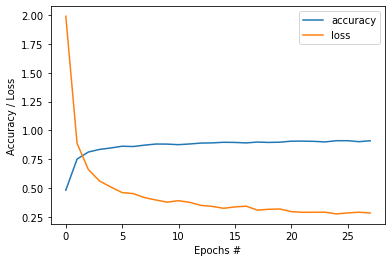

In [15]:
# Plotting
hist = history.history  # Taking a reference

plt.plot(hist["accuracy"], label="accuracy")  # Plotting the accuracy
plt.plot(hist["loss"], label="loss")  # Plot the loss

# Do this if you have validation sets used too
if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")  # Plotting the val accuracy
    plt.plot(hist["val_loss"], label="val_loss")  # Plot the val loss

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [16]:
model.save("plant_disease_detection.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Model and Categories download

Add IPython File linking for downloading the model and categories

In [17]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./plant_disease_detection.h5")

/content/plant_disease_detection.h5

In [18]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

# Link categories JSON
FileLink("categories.json")

/content/categories.json